<a href="https://colab.research.google.com/github/ogane0112/-AI-/blob/main/sckit_learn%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%2Bchainer%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#初めにこのセルを実行してください！
!pip install scikit-learn
!pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=293aec76a8d1c5ea620175a94ea58ece0e7df719dd03816099347d72a775d909
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


# scikit-learn入門(scikit-learnを用いた重回帰分析)

[chainer](https://tutorials.chainer.org/ja/09_Introduction_to_Scikit-learn.html)

## データセットの読み込み
**データの説明**  

  
| 属性名   | 説明                                           |
|----------|------------------------------------------------|
| CRIM     | 人口 1 人あたりの犯罪発生率                   |
| ZN       | 25,000 平方フィート以上の住宅区画が占める割合 |
| INDUS    | 小売業以外の商業が占める面積の割合            |
| CHAS     | チャールズ川の川沿いかどうか (0 or 1)         |
| NOX      | 窒素酸化物の濃度                             |
| RM       | 住居の平均部屋数                              |
| AGE      | 1940 年より前に建てられた持ち主が住んでいる物件の割合 |
| DIS      | 5 つのボストン雇用施設からの重み付き距離      |
| RAD      | 環状高速道路へのアクセシビリティ指標          |
| TAX      | $10,000 あたりの固定資産税率                   |
| PTRATIO  | 町ごとにみた教師 1 人あたりの生徒数           |
| B        | 町ごとにみた黒人の比率を Bk としたときの (Bk - 0.63)^2 の値 |
| LSTAT    | 給与の低い職業に従事する人口の割合            |
| MEDV     | 物件価格の中央値                               |
  
  

# アイリスデータを用いたディープラーニング

In [7]:
#アイリスデータの読み込み
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)
#chainerのデータ形式に変換する
x = x.astype('float32') #入力はfloat32
t = t.astype('int32') #出力はint32

In [9]:
#データセットの分割
# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [13]:
import chainer.links as L
import chainer.functions as F
from chainer import Sequential
l = L.Linear(3, 2)

In [15]:
# net としてインスタンス化
n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [19]:
import chainer
import chainer.optimizers as optimizers

optimizer = chainer.optimizers.SGD(lr=0.01)
optimizer.setup(net)

In [20]:
#エポック数
n_epoch = 30
n_batchsize = 16
import numpy as np

iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)


epoch: 0, iteration: 5, loss (train): 3.0914, loss (valid): 1.3394
epoch: 1, iteration: 10, loss (train): 1.1862, loss (valid): 1.0946
epoch: 2, iteration: 15, loss (train): 1.1000, loss (valid): 1.0427
epoch: 3, iteration: 20, loss (train): 1.0552, loss (valid): 1.0354
epoch: 4, iteration: 25, loss (train): 1.0692, loss (valid): 1.0429
epoch: 5, iteration: 30, loss (train): 1.0586, loss (valid): 1.0219
epoch: 6, iteration: 35, loss (train): 1.0442, loss (valid): 1.0151
epoch: 7, iteration: 40, loss (train): 1.0339, loss (valid): 1.0174
epoch: 8, iteration: 45, loss (train): 1.0413, loss (valid): 1.0355
epoch: 9, iteration: 50, loss (train): 1.0680, loss (valid): 1.0676
epoch: 10, iteration: 55, loss (train): 1.0580, loss (valid): 1.0082
epoch: 11, iteration: 60, loss (train): 1.0356, loss (valid): 0.9923
epoch: 12, iteration: 65, loss (train): 1.0201, loss (valid): 0.9880
epoch: 13, iteration: 70, loss (train): 1.0249, loss (valid): 0.9792
epoch: 14, iteration: 75, loss (train): 1.014

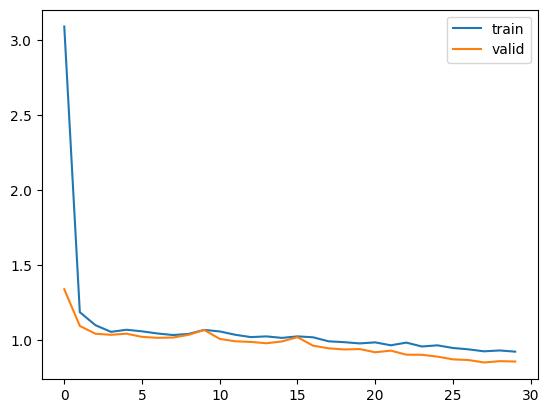

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

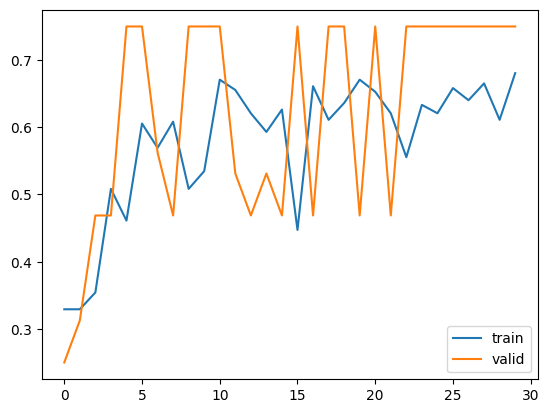

In [22]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

In [24]:
# テストデータで予測値を計算
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)
#分類精度を計算
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.6, dtype=float32)

In [25]:
chainer.serializers.save_npz('my_iris.net', net)

In [26]:
!ls

my_iris.net  sample_data


In [28]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

chainer.serializers.load_npz('my_iris.net', loaded_net)

In [30]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

np.argmax(y_test[0,:].array)

2